<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset-LSTM/blob/main/RNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli Kütüphaneler
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization, Input, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Veri Yükleme ---
def load_dreamer_data(file_path, max_length=1000):
    data = sio.loadmat(file_path)
    eeg_data_list = []
    score_valence_list = []

    for participant in range(23):
        for video in range(18):
            try:
                # EEG verisini yükle
                eeg_data = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0]
                score_valence = data['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0]

                # Veriyi zaman boyutuna göre kes veya doldur
                if eeg_data.shape[0] < max_length:
                    padding_shape = ((0, max_length - eeg_data.shape[0]), (0, 0))
                    eeg_data_padded = np.pad(eeg_data, padding_shape, mode='constant', constant_values=0)
                else:
                    eeg_data_padded = eeg_data[:max_length]

                # Veriyi listelere ekle
                eeg_data_list.append(eeg_data_padded)
                score_valence_list.append(score_valence)

            except Exception as e:
                print(f"Error for Participant {participant}, Video {video}: {e}")

    return np.array(eeg_data_list), np.array(score_valence_list)

In [ ]:
# --- EEG FFT Özellik Çıkarma ---
def extract_fft_features(eeg_data, max_length=1000):
    fft_features = np.abs(np.fft.fft(eeg_data, axis=1))  # FFT al
    fft_features = fft_features[:, :eeg_data.shape[1] // 2, :]  # Pozitif frekanslar (500 zaman adımı)

    # FFT zaman boyutunu EEG verisi zaman boyutuna uyumlu hale getirme (sıfırlarla doldurma)
    padding_shape = ((0, 0), (0, max_length - fft_features.shape[1]), (0, 0))
    fft_features_padded = np.pad(fft_features, padding_shape, mode='constant', constant_values=0)

    return fft_features_padded

In [ ]:
# --- EEG FFT Özellik Çıkarma ---
def extract_fft_features(eeg_data, max_length=1000):
    fft_features = np.abs(np.fft.fft(eeg_data, axis=1))  # FFT al
    fft_features = fft_features[:, :eeg_data.shape[1] // 2, :]  # Pozitif frekanslar

    # Zaman boyutunu doldur
    padding_shape = ((0, 0), (0, max_length - fft_features.shape[1]), (0, 0))
    fft_features_padded = np.pad(fft_features, padding_shape, mode='constant', constant_values=0)
    return fft_features_padded

# Ana Program

In [ ]:
# --- 1. Veri Yükleme ---
file_path = "/content/drive/MyDrive/Colab Notebooks/DREAMER.mat"
eeg_data, score_valence = load_dreamer_data(file_path)
print(f"Toplam EEG Verisi: {eeg_data.shape}")
print(f"Toplam ScoreValence: {score_valence.shape}")
print(f"ScoreValence Örnekleri: {score_valence[:10]}")

Toplam EEG Verisi: (414, 1000, 14)
Toplam ScoreValence: (414,)
ScoreValence Örnekleri: [4 3 5 4 4 1 5 1 1 5]


In [ ]:
# --- 2. Etiketleri İkili Hale Getirme ---
labels = np.array([1 if score >= 4 else 0 for score in score_valence])
print(f"Label Distribution: {np.unique(labels, return_counts=True)}")

Label Distribution: (array([0, 1]), array([251, 163]))


In [ ]:
# --- 3. FFT Özelliklerini Çıkarma ---
eeg_data_fft = extract_fft_features(eeg_data)
print(f"FFT Özelliklerinin Boyutu: {eeg_data_fft.shape}")

FFT Özelliklerinin Boyutu: (414, 1000, 14)


In [ ]:
# --- 4. EEG Zaman ve Frekans Özelliklerini Birleştirme ---
eeg_data_combined = np.concatenate([eeg_data, eeg_data_fft], axis=2)
print(f"Birleştirilmiş EEG Verisi Boyutu: {eeg_data_combined.shape}")

Birleştirilmiş EEG Verisi Boyutu: (414, 1000, 28)


In [ ]:
# 5. Frekans Alanını Normalize Etme
scaler = StandardScaler()
eeg_data_combined = eeg_data_combined.reshape(eeg_data_combined.shape[0], -1)
eeg_data_combined = scaler.fit_transform(eeg_data_combined)
eeg_data_combined = eeg_data_combined.reshape(-1, 2000, 14)

In [ ]:
# 6. Eğitim/Test Seti Ayırma
X_train, X_test, y_train, y_test = train_test_split(
    eeg_data_combined, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
# --- Veri Dengesizliği SMOTE ile Giderme ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_resampled = X_train_resampled.reshape(-1, 2000, 14)
print(f"Yeni Etiket Dağılımı: {np.unique(y_train_resampled, return_counts=True)}")

Yeni Etiket Dağılımı: (array([0, 1]), array([201, 201]))


In [ ]:
# Veri Artırma Fonksiyonları
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def time_shift(data, shift=50):
    return np.roll(data, shift, axis=1)

# Veri Artırma
X_train_aug = np.concatenate([X_train_resampled, add_noise(X_train_resampled), time_shift(X_train_resampled)], axis=0)
y_train_aug = np.concatenate([y_train_resampled, y_train_resampled, y_train_resampled], axis=0)

print("Veri Artırma Tamamlandı. Yeni Eğitim Veri Şekli:", X_train_aug.shape)

Veri Artırma Tamamlandı. Yeni Eğitim Veri Şekli: (1206, 2000, 14)


In [ ]:
# RNN Modeli
model = Sequential([
    Input(shape=(2000, 14)),  # Giriş şekli: (zaman adımı, özellik sayısı)

    # İlk SimpleRNN Katmanı
    SimpleRNN(128, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    # İkinci SimpleRNN Katmanı
    SimpleRNN(64, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    # Üçüncü SimpleRNN Katmanı
    SimpleRNN(32, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    # Dense Katmanları
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Çıkış katmanı
])

In [ ]:
# Model Derleme
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Modeli Eğitme
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,  # RNN modellerinde batch size küçültmek öğrenmeyi iyileştirebilir
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
13/13 [==============================] - 44s 3s/step - loss: 2.5825 - accuracy: 0.5199 - val_loss: 2.4130 - val_accuracy: 0.5542 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 39s 3s/step - loss: 2.5550 - accuracy: 0.5000 - val_loss: 2.4167 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 37s 3s/step - loss: 2.4728 - accuracy: 0.4776 - val_loss: 2.3465 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 39s 3s/step - loss: 2.4206 - accuracy: 0.4975 - val_loss: 2.2846 - val_accuracy: 0.5542 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 36s 3s/step - loss: 2.3368 - accuracy: 0.5473 - val_loss: 2.2427 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 39s 3s/step - loss: 2.3007 - accuracy: 0.5025 - val_loss: 2.1959 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 39s 3s/step - loss: 2.2780 - a

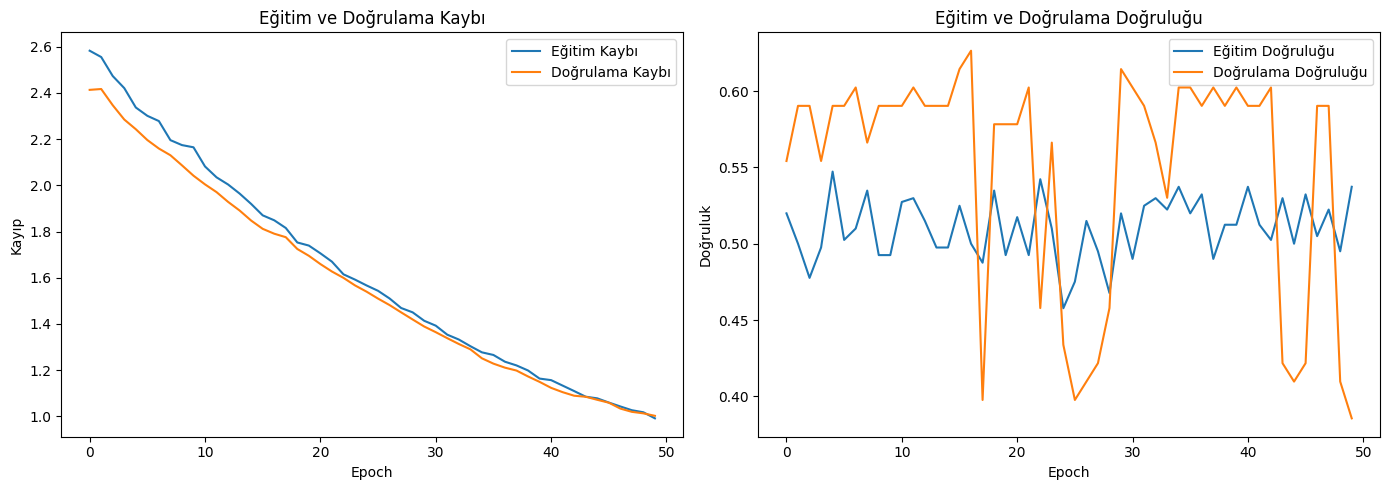

In [ ]:
# --- 12. Eğitim Sonuçlarını Çizdirme ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title("Eğitim ve Doğrulama Kaybı")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title("Eğitim ve Doğrulama Doğruluğu")
plt.tight_layout()
plt.show()

In [ ]:
# --- 13. Test Performansı ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Tahmin Et
all_preds = (model.predict(X_test) > 0.5).astype(int).flatten()
all_labels = y_test

# Karışıklık Matrisi ve Classification Report
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))


Final Test Accuracy: 0.3855
3/3 [==============================] - 2s 358ms/step
Confusion Matrix:
 [[ 0 50]
 [ 1 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.39      0.97      0.56        33

    accuracy                           0.39        83
   macro avg       0.20      0.48      0.28        83
weighted avg       0.16      0.39      0.22        83

